In [0]:
import pandas as pd
import scipy.misc
import random
import imageio
import numpy as np
from sklearn.cluster import KMeans
from scipy import stats
import pylab as plt
import glob
import multiprocessing
from  sklearn.metrics import pairwise_distances_argmin_min
import statistics
import cv2 as cv
import glob
from pathlib import Path
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, concatenate, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam

Using TensorFlow backend.


In [0]:
def unet(input_size =(240, 320, 1)):
    inputImg = Input(input_size)
    
    #conv_in block -
    conv_in = Conv2D(64, 3, padding = 'same', activation = 'relu', )(inputImg)
    conv_in = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(conv_in)

    #downConvBlock1
    dcB1 = MaxPooling2D(pool_size=(2, 2))(conv_in)
    dcB1 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(dcB1)
    dcB1 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(dcB1)
    
    #downConvBlock2
    dcB2 = MaxPooling2D(pool_size=(2, 2))(dcB1)
    dcB2 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(dcB2)
    dcB2 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(dcB2)
    
    #downConvBlock3
    dcB3 = MaxPooling2D(pool_size=(2, 2))(dcB2)
    dcB3 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(dcB3)
    dcB3 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(dcB3)
    
    #downConvBlock4
    dcB4 = MaxPooling2D(pool_size=(2, 2))(dcB3)
    dcB4 = Conv2D(1024, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(dcB4)
    dcB4 = Conv2D(1024, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(dcB4)
    #MAKE A DECISION ON DROUPOUT HERE
    
    #upConvBlock1
    ucB1 = Conv2D(512, 2, padding = 'same',activation = 'relu', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(dcB4))
    ucB1 = concatenate([dcB3,ucB1], axis = 3)
    ucB1 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(ucB1)
    ucB1 = Conv2D(512, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(ucB1)
    
    #upConvBlock2
    ucB2 = Conv2D(256, 2, padding = 'same',activation = 'relu', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(ucB1))
    ucB2 = concatenate([dcB2,ucB2], axis = 3)
    ucB2 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(ucB2)
    ucB2 = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(ucB2)
    
    #upConvBlock3
    ucB3 = Conv2D(128, 2, padding = 'same',activation = 'relu', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(ucB2))
    ucB3 = concatenate([dcB1,ucB3], axis = 3)
    ucB3 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(ucB3)
    ucB3 = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(ucB3)
    
    #upConvBlock4
    ucB4 = Conv2D(64, 2, padding = 'same',activation = 'relu', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(ucB3))
    ucB4 = concatenate([conv_in,ucB4], axis = 3)
    ucB4 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(ucB4)
    ucB4 = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(ucB4)
    
    #conv_out block
    co = Conv2D(1, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(ucB4)
    outputImg = Conv2D(1, 1, activation = 'sigmoid')(co)
    
    model = Model(input = inputImg, output = outputImg)
    model.compile(optimizer = keras.optimizers.Adam(lr = 1e-2), metrics = ['accuracy'], loss = 'binary_crossentropy')
    return model

In [0]:
def predictModel(fileLocation, model, inputType, inpaintingType):
    files = glob.glob(fileLocation)
    images = []
    for f in files:
        images.append(f)
    
    #Is there an easier way to do this in python - like in java?
    if inputType != 3:
        sub = 1
    else:
        sub = 2
    
    networkInput = []
    networkInput2 = []
    colourImages = []
    
    for i in range(len(images) - sub):
        image = cv.imread(images[i], 0)
        nextImage = cv.imread(images[i+1], 0)
        greyscaleDiff = np.subtract(nextImage, image)
        networkInput.append(greyscaleDiff)
        if inputType == 3:
            nextNextImage = cv.imread(images[i+2], 0)
            greyscaleDiff = np.subtract(nextNextImage, image)
            networkInput2.append(greyscaleDiff)
            
    for i in range(len(images) - sub):
        colourImages.append(cv.imread(images[i], 1))
    colourImages = np.array(colourImages).reshape(-1, 240, 320, 3)/255
        
    networkInput = np.array(networkInput).reshape(-1, 240, 320, 1)/255
    
    if inputType == 2:
        networkInput = np.concatenate((networkInput, colourImages), axis = 3)
    if inputType == 3:
        networkInput2 = np.array(networkInput2).reshape(-1, 240, 320, 1)/255
        networkInput = np.concatenate((networkInput, networkInput2, colourImages), axis = 3)
        
    predictedMasks = model.predict(networkInput)
    #return predictedMasks
    #Do we then need to multiply back out by 255?
    predictedMasks = predictedMasks*255
    return predictedMasks
    colourImages = colourImages*255
    
    rows = len(predictedMasks[0])
    cols = len(predictedMasks[0][0])
    
    potentialVals = [[[] for c in range(0, cols)] for r in range(0,rows)]
    #Check if this is inclusive of oth boundries
    for n in range(0, len(predictedMasks)):
        image = colourImages[n]
        mask = predictedMasks[n]
        for r in range(0, rows):
            for c in range(0, cols):
                if (mask[r][c][0] < 40):
                    potentialVals[r][c].append(image[r][c])

    finalMask = np.zeros((240, 320, 3))
    nearFinalImage = np.zeros((240, 320, 3))
    for r in range(0, rows):
        for c in range(0, cols):
            #include limit for more than 1 - potential to come back and change this val
            nonMaskAppearances = len(potentialVals[r][c])
            if nonMaskAppearances >  5:
                for colour in range(0, 3):
                    nearFinalImage[r][c][colour] = np.median([potentialVals[r][c][j][colour] for j in range(0, nonMaskAppearances)])
            else:
                finalMask[r][c] = 255
    finalMask = finalMask.astype(int)
    nearFinalImage = nearFinalImage.astype(int)
    cv.imwrite('hiddenmask.png',finalMask)
    cv.imwrite('hidden.png', nearFinalImage.astype(int))
    if inpaintingType == 1:
        return cv.inpaint(cv.imread('hidden.png'), cv.imread('hiddenmask.png', 0), 3, cv.INPAINT_TELEA)
    else:
        return cv.inpaint(cv.imread('hidden.png'), cv.imread('hiddenmask.png', 0), 3, cv.INPAINT_NS)
    
    
    

In [0]:
from keras.models import model_from_json
#For Input Type 1:
json_file = open('modelV1Final2_testtex.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("modelV1Final2_testtex.h5")
print("Model 1 Loaded")














Model 1 Loaded


In [0]:
predictionMod1 = predictModel('TESTIMAGESET/*.jpg', loaded_model, 1, 1)

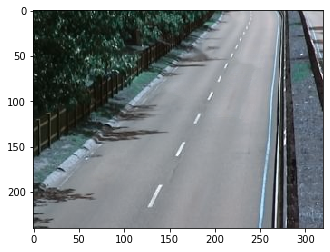

In [0]:
plt.imshow(prediction)